In [2]:
import pandas as pd
import numpy as np
from IPython.display import display

# Loading Data and Documentation

In [3]:
# Load the data into a DataFrame
data_file_path = "../data/TBI PUD 10-08-2013.csv"
df_data = pd.read_csv(data_file_path)
df_original = df_data

# Load Documentation
documentation_file_path = "../data/TBI PUD Documentation 10-08-2013.xlsx"
df_doc = pd.read_excel(documentation_file_path)[9:]

# Set the first row as column headers
df_doc.columns = df_doc.iloc[0]  # Assign the first row as column names
df_doc = df_doc[1:].reset_index(drop=True)  # Remove the first row and reset index

# Functions for Feature Explanation 

In [4]:
def get_variable_info(variable_name, df_data, df_doc=None, verbose = False):
    """
    Given a variable name (column title from df_data), this function returns:
    - The full column from df_data as a DataFrame.
    - The corresponding row from df_doc where 'Variable Name' matches, also as a DataFrame.

    Parameters:
        variable_name (str): The name of the variable (column title from df_data).
        df_data (pd.DataFrame): The main dataset.
        df_doc (pd.DataFrame): The documentation dataset. If None, will just return column.

    Displays:
    - Data column for format and variable
    - Data information and notes

    Returns:
    - The full column from df_data
    """
    if variable_name not in df_data.columns:
        raise ValueError(f"'{variable_name}' not found in df_data columns.")

    # Extract the full column and format it as a DataFrame
    column_data = pd.DataFrame(df_data[variable_name])

    # Find the corresponding row in df_doc
    if(df_doc is not None):
        doc_row = df_doc[df_doc["Variable Name"] == variable_name]

    # Display both DataFrames
    if(verbose):
        print(f"\nData Column for '{variable_name}':")
        display(column_data)

        print(f"\nDocumentation Row for '{variable_name}':")
    
    if(verbose):
        if(df_doc is not None):
            display(doc_row)

    if(df_doc is not None):

        # Extract the 'Notes' column if it exists
        notes_value = doc_row["Notes"].values[0] if "Notes" in df_doc.columns and not doc_row.empty else None

        # Extract the 'Label/Description' column if it exists
        desc_value = doc_row["Label/Description"].values[0] if "Label/Description" in df_doc.columns and not doc_row.empty else None

        # Extract the 'Format Name and Values' column if it exists
        format_value = doc_row["Format Name and Values"].values[0] if "Format Name and Values" in df_doc.columns and not doc_row.empty else None

        if(verbose):
            print("\nReturned Notes:")
            print(notes_value)

            print("\nReturned Label/Description:")
            print(desc_value)

            print("\nReturned Format Name and Values:")
            print(format_value)

    return df_data[variable_name]

In [5]:
import pandas as pd
import os

# Dictionary to track how many times each variable has been processed
var_counter = {}

def get_frequency_table(data_column, var_name):
    """
    Given a Pandas Series, this function returns a well-formatted frequency table
    and saves it as a LaTeX-styled table.

    Parameters:
        data_column (pd.Series): A column from a DataFrame.
        var_name (str): The name of the variable (for labeling output files).

    Returns:
        pd.DataFrame: A frequency table with unique values, their counts, and percentages.
    """
    if not isinstance(data_column, pd.Series):
        raise TypeError("Input must be a Pandas Series (a single column from a DataFrame).")

    # Track how many times this variable has been processed
    var_counter[var_name] = var_counter.get(var_name, 0) + 1
    iteration = var_counter[var_name]

    # Compute frequency table including NaN values
    freq_table = data_column.value_counts(dropna=False).reset_index()
    freq_table.columns = ["Value", "Frequency"]  # Rename columns

    # Compute percentage table
    freq_table["Percentage"] = (freq_table["Frequency"] / freq_table["Frequency"].sum()) * 100
    freq_table["Percentage"] = freq_table["Percentage"].apply(lambda x: f"{x:.2f}%")  # Format percentages

    # Convert NaN values in "Value" column to string for display
    freq_table["Value"] = freq_table["Value"].astype(str).replace("nan", "NaN")

    # Print the table (Jupyter-style output)
    print(f"\nFrequency Table for {var_name} (Run {iteration})")
    display(freq_table)  # Displays it exactly like Pandas in Jupyter

    # Save the table as a LaTeX-styled table
    output_dir = "../figs/freq_tables/"
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
    output_path_tex = f"{output_dir}/freq_{var_name}_{iteration}.tex"

    # Save LaTeX-styled table
    with open(output_path_tex, "w") as f:
        f.write(freq_table.style.to_latex())

    print(f"Saved LaTeX-styled table: {output_path_tex}")

    return freq_table


In [6]:
def list_column_data_types(df):
    """
    Lists the unique data types present in each column of a DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        pd.DataFrame: A DataFrame with columns ['Column', 'Data_Types'].
    """
    column_types = []
    
    for column in df.columns:
        unique_types = set(df[column].apply(lambda x: type(x).__name__ if pd.notna(x) else 'NaN'))
        column_types.append({'Column': column, 'Data_Types': ', '.join(unique_types)})
    
    return pd.DataFrame(column_types)

# Explaining Missing Data

Many of our features have both NaN and a value of 92, the latter of which indicates either the question being non-applicable to patients or that the data is missing. For our data cleaning, we will make decisions on each feature, deciding which of these values we can deduce and which ones we will convert to NaN values.

In [7]:
variable_name = "IndSeiz"
column_data = get_variable_info(variable_name, df_data, df_doc)
_ = get_frequency_table(column_data, variable_name)


Frequency Table for IndSeiz (Run 1)


,Value,Frequency,Percentage
0,92,26474,61.00%
1,0,16423,37.84%
2,1,502,1.16%


Saved LaTeX-styled table: ../figs/freq_tables//freq_IndSeiz_1.tex


In [8]:
variable_name = "SeizOccur"
column_data = get_variable_info(variable_name, df_data, df_doc)
_ = get_frequency_table(column_data, variable_name)


Frequency Table for SeizOccur (Run 1)


,Value,Frequency,Percentage
0,92.0,42796,98.61%
1,1.0,253,0.58%
2,2.0,210,0.48%
3,NaN,71,0.16%
4,3.0,69,0.16%


Saved LaTeX-styled table: ../figs/freq_tables//freq_SeizOccur_1.tex


# Data Cleaning

For our data cleaning, we decided to focus on feature construction and cleaning for vomit and seizure variables, as according to the domain expert Nurse Cathy (source in documents folder) vomiting and seizures are two of the signs for TBI (in addition to pupil abnormalities which GCSEye covers). More discussion is in the exploratory data analysis notebook; however, the key note is that the other key symptoms she outlines are not in our dataset.

### Seizure Feature Construction and Cleaning

To construct a robust seizure index, we need to address the limitations of existing seizure-related variables. The **IndSeiz** variable, which indicates seizure occurrence, may produce false negatives since individuals who did not undergo a procedure could be misclassified as seizure-free. The **Seiz** variable captures post-trauma seizures but contains missing values that could be left as unknown or imputed using other seizure-related features. Similarly, **SeizOccur** (timing of the seizure) and **SeizLen** (seizure duration) require careful cleaning, as missing values or "not applicable" entries might indicate true absence or unrecorded data. Given these issues, we propose constructing a new indicator variable that deduces whether a patient has ever experienced a seizure. By leveraging existing seizure-related features, we can construct a new feature and reduce the number of features necessary for analysis.

We can use our clean.py file to clean our seizure data, ceating a comprehensive seizure indicator (HadSeiz), identifying contradictions in medical records, and standardizing missing values and inconsistencies.

In [9]:
import clean

# Apply the seizure cleaning function
df_data = clean.clean_seiz(df_data)

/mnt/c/Users/Micha/Projects/Berkeley_Masters/Spring_2025/stat-214/stat-214/lab1/code/clean.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'contradiction' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  row["HadSeiz"] = "contradiction"


In [10]:
variable_name = "HadSeiz"
column_data = get_variable_info(variable_name, df_data, df_doc)
_ = get_frequency_table(column_data, variable_name)


Frequency Table for HadSeiz (Run 1)


,Value,Frequency,Percentage
0,0.0,42529,98.00%
1,1.0,582,1.34%
2,NaN,202,0.47%
3,contradiction,86,0.20%


Saved LaTeX-styled table: ../figs/freq_tables//freq_HadSeiz_1.tex


In the above process, we deduced from the other seizure features if the patient has ever had a seizure before, critically thinking through the data collection and documentation. For example, we know that IndSeiz is only completed for people who were in consideration for a CT, meaning that a missing value would not be a perfect feature if a patient has had a seizure or not before. As you can see compared to IndSeiz, we were able to account for almost all of the patient's previous seizure status.

In [11]:
variable_name = "SeizOccur"
column_data = get_variable_info(variable_name, df_data, df_doc)
_ = get_frequency_table(column_data, variable_name)


Frequency Table for SeizOccur (Run 2)


,Value,Frequency,Percentage
0,0.0,42529,98.00%
1,NaN,338,0.78%
2,1.0,253,0.58%
3,2.0,210,0.48%
4,3.0,69,0.16%


Saved LaTeX-styled table: ../figs/freq_tables//freq_SeizOccur_2.tex


Moreover, through our data cleaning, we have been able to account for around ~42,000 more patients than before in our SeizOccur variable. We have similar results for other variables. However, we only changed IndSeiz's variable names to NaN so we could keep the information that these patients were considering a CT scan.

### Vomiting Feature Cleaning

We will fill in the missing values for the vomit data we already have and create two more features: one for counting evidence for vomiting and one for lack of evidence.

In [12]:
variable_name = "VomitNbr"
column_data = get_variable_info(variable_name, df_data)
_ = get_frequency_table(column_data, variable_name)


Frequency Table for VomitNbr (Run 1)


,Value,Frequency,Percentage
0,NaN,37892,87.31%
1,1.0,2189,5.04%
2,3.0,2173,5.01%
3,2.0,1145,2.64%


Saved LaTeX-styled table: ../figs/freq_tables//freq_VomitNbr_1.tex


In [13]:
df_data = clean.clean_vomit(df_data)

/mnt/c/Users/Micha/Projects/Berkeley_Masters/Spring_2025/stat-214/stat-214/lab1/code/clean.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data["VomitEvidenceCount"] = 0
/mnt/c/Users/Micha/Projects/Berkeley_Masters/Spring_2025/stat-214/stat-214/lab1/code/clean.py:124: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data["VomitLackOfEvidenceCount"] = 0
/mnt/c/Users/Micha/Projects/Berkeley_Masters/Spring_2025/stat-214/stat-214/lab1/code/clean.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.ma

In [14]:
variable_name = "VomitEvidenceCount"
column_data = get_variable_info(variable_name, df_data)
_ = get_frequency_table(column_data, variable_name)


Frequency Table for VomitEvidenceCount (Run 1)


,Value,Frequency,Percentage
0,0,37580,86.59%
1,3,2503,5.77%
2,4,2472,5.70%
3,2,558,1.29%
4,1,286,0.66%


Saved LaTeX-styled table: ../figs/freq_tables//freq_VomitEvidenceCount_1.tex


In [15]:
variable_name = "VomitLackOfEvidenceCount"
column_data = get_variable_info(variable_name, df_data)
_ = get_frequency_table(column_data, variable_name)


Frequency Table for VomitLackOfEvidenceCount (Run 1)


,Value,Frequency,Percentage
0,4,24693,56.90%
1,3,13065,30.10%
2,0,3131,7.21%
3,1,2026,4.67%
4,2,484,1.12%


Saved LaTeX-styled table: ../figs/freq_tables//freq_VomitLackOfEvidenceCount_1.tex


### Cleaning Labels

Now we filter the dataset to retain only the key columns related to TBI, extracting rows where "PosIntFinal" is NaN into a separate DataFrame.

In [16]:
# Define relevant columns
columns_to_keep = ["PatNum", "PosCT", "DeathTBI", "HospHeadPosCT", "PosIntFinal"]

# Filter dataset to keep only relevant columns
df_filtered = df_data[columns_to_keep]

# Create a DataFrame with only NaN values in 'PosIntFinal'
nan_df_class = df_filtered[df_filtered["PosIntFinal"].isna()]

nan_df_class

,PatNum,PosCT,DeathTBI,HospHeadPosCT,PosIntFinal
75,76.0,0.0,NaN,0.0,NaN
781,782.0,0.0,NaN,0.0,NaN
947,948.0,0.0,0.0,0.0,NaN
6112,6113.0,0.0,0.0,0.0,NaN
9541,9542.0,0.0,0.0,0.0,NaN
10514,10515.0,0.0,0.0,0.0,NaN
10721,10722.0,NaN,0.0,0.0,NaN
15233,15234.0,NaN,0.0,0.0,NaN
23581,23582.0,0.0,0.0,0.0,NaN
24073,24074.0,0.0,0.0,0.0,NaN


Given the above, it seems that there are a few people that should surely be classified as TBI based on the PosCT feature. We will make the respective adjustments. The other patients we can drop because they seem unlikely to be positive for TBI. We choose to drop them given the two possible cases:

1. These rows are net-positive TBI, meaning we would be making a bad decision by labeling them all TBI negative.

2. These rows are net-negative TBI, meaning would not lose much information by dropping them as we already have 42000+ TBI negative individuals in our dataset.

We wanted to show the steps and thinking behind our cleaning, but we can do these steps all at once with our clean_data function:

In [17]:
df_data = pd.read_csv(data_file_path)

df_data = clean.clean_data(df_data)

/mnt/c/Users/Micha/Projects/Berkeley_Masters/Spring_2025/stat-214/stat-214/lab1/code/clean.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'contradiction' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  row["HadSeiz"] = "contradiction"
/mnt/c/Users/Micha/Projects/Berkeley_Masters/Spring_2025/stat-214/stat-214/lab1/code/clean.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data["VomitEvidenceCount"] = 0
/mnt/c/Users/Micha/Projects/Berkeley_Masters/Spring_2025/stat-214/stat-214/lab1/code/clean.py:124: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

This function also replaces missing and non-applicable values with NaN.

GCSEye is one of our important features which we can see how we changed unknown values to NaN.

In [18]:
variable_name = "GCSEye"
column_data = get_variable_info(variable_name, df_data)
_ = get_frequency_table(column_data, variable_name)


Frequency Table for GCSEye (Run 1)


,Value,Frequency,Percentage
0,4.0,41132,94.81%
1,NaN,1288,2.97%
2,3.0,505,1.16%
3,1.0,291,0.67%
4,2.0,166,0.38%


Saved LaTeX-styled table: ../figs/freq_tables//freq_GCSEye_1.tex


# Exploring Relationships

/tmp/ipykernel_168487/1783864863.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_1 = df_hadseiz_1.pivot_table(index="VomitNbr", columns="HadSeiz", aggfunc="size", fill_value=0)
/tmp/ipykernel_168487/1783864863.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_0 = df_hadseiz_0.pivot_table(index="VomitNbr", columns="HadSeiz", aggfunc="size", fill_value=0)


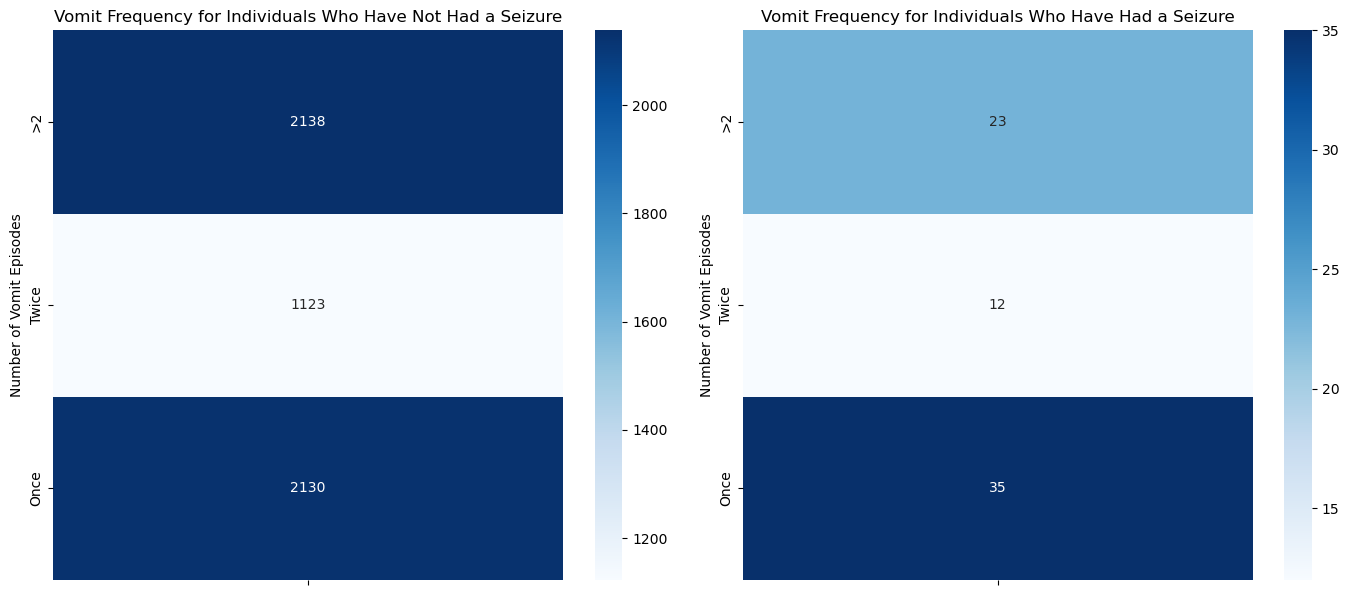

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for HadSeiz = 1 and 0
df_hadseiz_1 = df_data[df_data["HadSeiz"] == 1].copy()
df_hadseiz_0 = df_data[df_data["HadSeiz"] == 0].copy()

# Define new labels for VomitNbr
vomit_labels = {1: "Once", 2: "Twice", 3: ">2"}

# Replace VomitNbr values with new labels and sort in reverse order
df_hadseiz_1["VomitNbr"] = df_hadseiz_1["VomitNbr"].replace(vomit_labels)
df_hadseiz_0["VomitNbr"] = df_hadseiz_0["VomitNbr"].replace(vomit_labels)

df_hadseiz_1["VomitNbr"] = pd.Categorical(df_hadseiz_1["VomitNbr"], categories=[">2", "Twice", "Once"], ordered=True)
df_hadseiz_0["VomitNbr"] = pd.Categorical(df_hadseiz_0["VomitNbr"], categories=[">2", "Twice", "Once"], ordered=True)

# Create pivot tables for heatmaps with new labels
heatmap_1 = df_hadseiz_1.pivot_table(index="VomitNbr", columns="HadSeiz", aggfunc="size", fill_value=0)
heatmap_0 = df_hadseiz_0.pivot_table(index="VomitNbr", columns="HadSeiz", aggfunc="size", fill_value=0)

# Rename column headers for readability
heatmap_1.columns = [""]
heatmap_0.columns = [""]

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot heatmap for HadSeiz = 0 (Has Not Had a Seizure) on the left
sns.heatmap(heatmap_0, cmap="Blues", annot=True, fmt="d", ax=axes[0])
axes[0].set_xlabel("")
axes[0].set_ylabel("Number of Vomit Episodes")
axes[0].set_title("Vomit Frequency for Individuals Who Have Not Had a Seizure")

# Plot heatmap for HadSeiz = 1 (Has Had a Seizure) on the right
sns.heatmap(heatmap_1, cmap="Blues", annot=True, fmt="d", ax=axes[1])
axes[1].set_xlabel("")
axes[1].set_ylabel("Number of Vomit Episodes")
axes[1].set_title("Vomit Frequency for Individuals Who Have Had a Seizure")

# Adjust layout
plt.tight_layout()

# Save figure
save_path = "../figs/vomit_seizure_heatmap.png"
plt.savefig(save_path, dpi=300)
plt.show()


Based on the above heatmaps, patients are less likely to have had more than two vomit episodes if they have had a seizure before. This result may be counterintuitive at first as domain knowledge suggests that these are both symptoms of TBI; however, it may make sense given that patients who have experienced seizures may receive prompt medical attention, potentially reducing the occurrence of severe vomiting episodes. Additionally, vomiting often presents immediately after a traumatic brain injury (TBI), while seizures can develop later, suggesting different underlying mechanisms or stages of injury progression.

This counterintuitive finding is valuable for our machine learning modeling because it highlights the importance of not relying solely on traditional assumptions. Incorporating such unexpected patterns can enhance the model's ability to identify nuanced relationships within the data, leading to more accurate predictions.

The next three plots can be seen in the figs folder.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Age Distribution Plot
plt.figure(figsize=(12, 8))

# Create age groups
df_data['AgeGroup'] = (df_data['AgeinYears'] // 2) * 2
age_dist = df_data['AgeGroup'].value_counts().sort_index()

# Create the plot
plt.bar(age_dist.index, age_dist.values, color='#8884d8', alpha=0.7)
plt.plot(age_dist.index, age_dist.values, color='#4834d4', linewidth=2)

# Customize the plot
plt.title('Age Distribution of TBI Cases', fontsize=14, pad=20)
plt.xlabel('Age Group (Years)', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)

# Add x-axis labels
plt.xticks(age_dist.index, [f'{int(i)}-{int(i)+2}' for i in age_dist.index])

# Add grid
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(age_dist.values):
    plt.text(age_dist.index[i], v, str(int(v)), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../figs/age_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. GCS Score vs CT Positive Rate
plt.figure(figsize=(12, 8))

# Calculate positive CT rates for each GCS score
gcs_analysis = df_data[df_data['CTDone'] == 1].groupby('GCSTotal').agg({
    'PosCT': ['count', 'sum']
}).reset_index()

gcs_analysis.columns = ['GCS_Score', 'Total_Cases', 'Positive_CT']
gcs_analysis['Positive_Rate'] = (gcs_analysis['Positive_CT'] / gcs_analysis['Total_Cases'] * 100)

# Plot line with markers
plt.plot(gcs_analysis['GCS_Score'], gcs_analysis['Positive_Rate'], 
         marker='o', linewidth=2, color='#2ecc71', markersize=8)

# Customize the plot
plt.title('CT Positive Rate by GCS Score', fontsize=14, pad=20)
plt.xlabel('GCS Score', fontsize=12)
plt.ylabel('Positive CT Rate (%)', fontsize=12)

# Add grid
plt.grid(True, alpha=0.3)

# Add value labels
for x, y in zip(gcs_analysis['GCS_Score'], gcs_analysis['Positive_Rate']):
    plt.text(x, y + 1, f'{y:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../figs/gcs_ct_relationship.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. GCS Eye Score Analysis
plt.figure(figsize=(12, 8))

# Calculate rates for eye scores
eye_analysis = df_data[df_data['CTDone'] == 1].groupby('GCSEye').agg({
    'PosCT': ['count', 'sum'],
    'Neurosurgery': 'sum'
}).reset_index()

eye_analysis.columns = ['Eye_Score', 'Total_Cases', 'Positive_CT', 'Neurosurgery']
eye_analysis['CT_Positive_Rate'] = (eye_analysis['Positive_CT'] / eye_analysis['Total_Cases'] * 100)
eye_analysis['Neurosurgery_Rate'] = (eye_analysis['Neurosurgery'] / eye_analysis['Total_Cases'] * 100)

# Set bar width
bar_width = 0.35

# Create bars
bars1 = plt.bar(eye_analysis['Eye_Score'] - bar_width/2, eye_analysis['CT_Positive_Rate'], 
                bar_width, label='CT Positive Rate', color='#3498db')
bars2 = plt.bar(eye_analysis['Eye_Score'] + bar_width/2, eye_analysis['Neurosurgery_Rate'], 
                bar_width, label='Neurosurgery Rate', color='#e74c3c')

# Customize the plot
plt.title('GCS Eye Score: CT Positive & Neurosurgery Rates', fontsize=14, pad=20)
plt.xlabel('GCS Eye Score', fontsize=12)
plt.ylabel('Rate (%)', fontsize=12)

# Create custom x-axis labels
plt.xticks(eye_analysis['Eye_Score'], 
           ['1 - No Opening', '2 - Pain', '3 - Voice', '4 - Spontaneous'])

# Add grid
plt.grid(True, alpha=0.3)

# Add legend
plt.legend()

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.savefig('../figs/eye_score_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# Print some key statistics
print("\nKey Statistics:")
print(f"Total number of cases: {len(df_data):,}")
print(f"Average age: {df_data['AgeinYears'].mean():.1f} years")
print(f"CT scan rate: {(df_data['CTDone'].mean() * 100):.1f}%")
print(f"Positive CT rate among scanned patients: {(df_data[df_data['CTDone'] == 1]['PosCT'].mean() * 100):.1f}%")

/tmp/ipykernel_168487/914815058.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data['AgeGroup'] = (df_data['AgeinYears'] // 2) * 2



Key Statistics:
Total number of cases: 43,382
Average age: 6.6 years
CT scan rate: 36.6%
Positive CT rate among scanned patients: 7.3%


Age Distribution Plot:
The age distribution of TBI cases reveals a striking pattern, with a significant peak in very young children aged 0-2 years (10,904 cases) followed by a steady decline through early childhood. This early peak likely reflects the vulnerability of toddlers as they develop mobility but lack coordination and risk awareness. A secondary, smaller peak appears in adolescence (ages 14-16), potentially corresponding to increased sports participation and risk-taking behaviors. This bimodal distribution has important implications for prevention strategies and clinical assessment approaches, as different age groups may require different evaluation criteria due to varying injury mechanisms and ability to communicate symptoms.

GCS Score vs CT Positive Rate:
The relationship between Glasgow Coma Scale (GCS) scores and positive CT findings demonstrates a clear inverse correlation, with dramatic differences in risk across the scale. Patients with lower GCS scores (3-5) show remarkably high positive CT rates ranging from 70% to 90%, while those with mild TBI (GCS 13-15) have rates below 22%. This stark contrast validates the use of GCS as a powerful predictor of intracranial injury. Notably, there's a clear threshold effect around GCS 12, where positive CT rates drop significantly, suggesting a potential decision point for clinical protocols. The extremely low positive rate (4.5%) for GCS 15 patients highlights the potential for reducing unnecessary CT scans in this large subgroup.

GCS Eye Score Analysis:
The analysis of GCS Eye scores reveals a strong predictive relationship with both CT findings and neurosurgical interventions. Patients with no eye opening (score 1) demonstrate the highest risk profile, with a 68.4% CT positive rate and a 36.5% neurosurgery rate. These rates decrease progressively with improving eye scores, dropping dramatically to 5.3% CT positive and 0.4% neurosurgery rates for patients with spontaneous eye opening (score 4). The parallel decline in both metrics suggests that eye response alone could serve as a powerful initial screening tool in the emergency setting. The large gap between CT positive rates and neurosurgery rates across all categories also indicates that many positive CT findings may not require surgical intervention, particularly in patients with better eye scores.

# Prediction

### Decision Trees

The first decision tree we make has a high true positive rate; however, the model also has a 37% false positive rate, meaning we would be suggesting too many patients to get unnecessary CT scans. However, medical professionals can still use this model in tandem with the latter -- more conservative -- decision tree: which we will discuss.

In [21]:
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Define candidate categorical features
candidate_features = ['HadSeiz', 'GCSEye', "VomitNbr", "VomitStart", "IndVomit", "VomitLast"]
target_variable = 'PosIntFinal'

# One-hot encode categorical variables
df_encoded = df_data.copy()
df_encoded = df_encoded.astype(str)  # Ensure all columns are string type for encoding
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

# Apply One-Hot Encoding
X_encoded = encoder.fit_transform(df_encoded[candidate_features])
feature_names = encoder.get_feature_names_out(candidate_features)

# Convert to DataFrame
X_encoded = pd.DataFrame(X_encoded, columns=feature_names, index=df_encoded.index)

# Add the encoded features to the dataset
df_encoded = df_encoded.drop(columns=candidate_features)  # Drop original categorical columns
df_encoded = pd.concat([df_encoded, X_encoded], axis=1)  # Add encoded features

# Define X and y
X = df_encoded[feature_names]  # Use only one-hot encoded features
y = df_encoded[target_variable]

# Apply undersampling to balance classes
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Check the new class distribution
unique, counts = np.unique(y_resampled, return_counts=True)
print("Balanced class distribution after undersampling:", dict(zip(unique, counts)))

# Initialize greedy feature selection
selected_features = []
best_score = 0

while len(selected_features) < len(feature_names):
    best_feature = None
    for feature in feature_names:
        if feature in selected_features:
            continue
        
        # Try adding this feature
        current_features = selected_features + [feature]
        X_subset = X_resampled[current_features]
        
        # Use Balanced Bagging to balance class distribution
        model = BalancedBaggingClassifier(
            estimator=DecisionTreeClassifier(random_state=42, max_depth=None),
            sampling_strategy=1.0,  # Ensure equal number of 0s and 1s
            random_state=42,
            n_estimators=50,  # Increase base estimators
            n_jobs=-1  # Use all CPU cores
        )

        score = np.mean(cross_val_score(model, X_subset, y_resampled, cv=5, scoring='accuracy'))
        
        if score > best_score:
            best_score = score
            best_feature = feature
    
    if best_feature is None:
        break  # No improvement found
    
    selected_features.append(best_feature)
    print(f"Added feature: {best_feature}, New score: {best_score:.4f}")

# Train final balanced bagging model with selected features
final_model_dt1 = BalancedBaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42, max_depth=None),
    sampling_strategy=1.0,
    random_state=42,
    n_estimators=50,
    n_jobs=-1
)
final_model_dt1.fit(X_resampled[selected_features], y_resampled)

# Predict on the training data
y_pred = final_model_dt1.predict(X_resampled[selected_features])

# Count occurrences of 0s and 1s in the predicted labels
unique, counts = np.unique(y_pred, return_counts=True)
print("Final predicted class distribution:", dict(zip(unique, counts)))

print(f"Final selected feature order: {selected_features}")

Balanced class distribution after undersampling: {'0.0': np.int64(766), '1.0': np.int64(766)}
Added feature: IndVomit_nan, New score: 0.7931
Added feature: HadSeiz_nan, New score: 0.7944
Added feature: GCSEye_4.0, New score: 0.7964
Added feature: GCSEye_nan, New score: 0.7996
Final predicted class distribution: {'0.0': np.int64(461), '1.0': np.int64(1071)}
Final selected feature order: ['IndVomit_nan', 'HadSeiz_nan', 'GCSEye_4.0', 'GCSEye_nan']


In [22]:
# Make predictions
y_pred = final_model_dt1.predict(X[selected_features])

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Compute proportions
total_positives = tp + fn  # Actual Positives
total_negatives = tn + fp  # Actual Negatives

sensitivity = tp / total_positives if total_positives > 0 else 0  # True Positive Rate (TPR)
specificity = tn / total_negatives if total_negatives > 0 else 0  # True Negative Rate (TNR)
false_positive_rate = fp / total_negatives if total_negatives > 0 else 0  # FPR
false_negative_rate = fn / total_positives if total_positives > 0 else 0  # FNR

# Print results
print(f"True Positives (TP): {tp} ({sensitivity:.4f} of actual positives)")
print(f"True Negatives (TN): {tn} ({specificity:.4f} of actual negatives)")
print(f"False Positives (FP): {fp} ({false_positive_rate:.4f} of actual negatives)")
print(f"False Negatives (FN): {fn} ({false_negative_rate:.4f} of actual positives)")

True Positives (TP): 765 (0.9987 of actual positives)
True Negatives (TN): 26434 (0.6203 of actual negatives)
False Positives (FP): 16182 (0.3797 of actual negatives)
False Negatives (FN): 1 (0.0013 of actual positives)


### Conservative Decision Tree

We provide a more conservative tree. Medical professionals can use this tree as a "highly recommended for CT scan" model while the previous tree could be considered a model where doctors can employ their medical discretion or patient-monitoring strategies.

In [23]:
# Define candidate categorical features
candidate_features = ['HadSeiz', 'GCSEye', "VomitNbr", "VomitStart", "IndVomit", "VomitLast", 'SFxBas', 'SFxPalp', 'AMS', 'LOCSeparate', 'Vomit', 'LocLen', 'High_impact_InjSev', 'HA_verb', 'HASeverity', 'ActNorm']
target_variable = 'PosIntFinal'

# One-hot encode categorical variables
df_encoded = df_data.copy().astype(str)  # Ensure all columns are string type
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(df_encoded[candidate_features])

# Get feature names and convert to DataFrame
feature_names = encoder.get_feature_names_out(candidate_features)
X_encoded = pd.DataFrame(X_encoded, columns=feature_names, index=df_encoded.index)

# **Remove unwanted one-hot encoded columns**
columns_to_remove = []
#columns_to_remove = ['IndVomit_unknown', 'HadSeiz_unknown', 'GCSEye_nan', 'VomitStart_unknown', 'VomitLast_unknown', 'VomitNbr_unknown', 'HadSeiz_contradiction']
X_encoded = X_encoded.drop(columns=[col for col in columns_to_remove if col in X_encoded.columns], errors='ignore')

# Drop original categorical columns and add the encoded ones
df_encoded = df_encoded.drop(columns=candidate_features, errors='ignore')
df_encoded = pd.concat([df_encoded, X_encoded], axis=1)

# Define X and y
X = df_encoded[X_encoded.columns]  # Use only one-hot encoded features
y = df_encoded[target_variable]

# Apply undersampling to balance classes
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Check the new class distribution
unique, counts = np.unique(y_resampled, return_counts=True)
print("Balanced class distribution after undersampling:", dict(zip(unique, counts)))

# Initialize greedy feature selection
selected_features = []
best_score = 0

# Function to force specific splits
def force_splits(features_to_include):
    global selected_features
    selected_features = [f for f in features_to_include if f in X_encoded.columns]
    print(f"Forcing split using features: {selected_features}")

# Force decision tree to split first on GCSEye_4.0 and then HadSeiz_1
force_splits(['IndVomit_1', 'HadSeiz_1'])

while len(selected_features) < len(X_encoded.columns):
    best_feature = None
    for feature in X_encoded.columns:
        if feature in selected_features:
            continue

        # Try adding this feature
        current_features = selected_features + [feature]
        X_subset = X_resampled[current_features]

        # Use Balanced Bagging to balance class distribution
        model = BalancedBaggingClassifier(
            estimator=DecisionTreeClassifier(random_state=42, max_depth=None),
            sampling_strategy=1.0,
            random_state=42,
            n_estimators=50,
            n_jobs=-1
        )

        score = np.mean(cross_val_score(model, X_subset, y_resampled, cv=5, scoring='accuracy'))

        if score > best_score:
            best_score = score
            best_feature = feature

    if best_feature is None:
        break  # No improvement found

    selected_features.append(best_feature)
    print(f"Added feature: {best_feature}, New score: {best_score:.4f}")

# Train final balanced bagging model with selected features
final_model_dt2 = BalancedBaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42, max_depth=None),
    sampling_strategy=1.0,
    random_state=42,
    n_estimators=50,
    n_jobs=-1
)
final_model_dt2.fit(X_resampled[selected_features], y_resampled)

# Predict on the training data
y_pred = final_model_dt2.predict(X_resampled[selected_features])

# Count occurrences of 0s and 1s in the predicted labels
unique, counts = np.unique(y_pred, return_counts=True)
print("Final predicted class distribution:", dict(zip(unique, counts)))

print(f"Final selected feature order: {selected_features}")

Balanced class distribution after undersampling: {'0.0': np.int64(766), '1.0': np.int64(766)}
Forcing split using features: []
Added feature: AMS_1.0, New score: 0.8290
Added feature: SFxBas_1.0, New score: 0.8401
Added feature: SFxPalp_1.0, New score: 0.8473
Added feature: SFxPalp_2.0, New score: 0.8519
Added feature: IndVomit_nan, New score: 0.8577
Added feature: ActNorm_nan, New score: 0.8623
Added feature: LocLen_4.0, New score: 0.8656
Added feature: SFxBas_nan, New score: 0.8662
Added feature: AMS_nan, New score: 0.8669
Added feature: VomitStart_nan, New score: 0.8675
Final predicted class distribution: {'0.0': np.int64(719), '1.0': np.int64(813)}
Final selected feature order: ['AMS_1.0', 'SFxBas_1.0', 'SFxPalp_1.0', 'SFxPalp_2.0', 'IndVomit_nan', 'ActNorm_nan', 'LocLen_4.0', 'SFxBas_nan', 'AMS_nan', 'VomitStart_nan']


In [24]:
# Make predictions
y_pred = final_model_dt2.predict(X[selected_features])

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Compute proportions
total_positives = tp + fn  # Actual Positives
total_negatives = tn + fp  # Actual Negatives

sensitivity = tp / total_positives if total_positives > 0 else 0  # True Positive Rate (TPR)
specificity = tn / total_negatives if total_negatives > 0 else 0  # True Negative Rate (TNR)
false_positive_rate = fp / total_negatives if total_negatives > 0 else 0  # FPR
false_negative_rate = fn / total_positives if total_positives > 0 else 0  # FNR

# Print results
print(f"True Positives (TP): {tp} ({sensitivity:.4f} of actual positives)")
print(f"True Negatives (TN): {tn} ({specificity:.4f} of actual negatives)")
print(f"False Positives (FP): {fp} ({false_positive_rate:.4f} of actual negatives)")
print(f"False Negatives (FN): {fn} ({false_negative_rate:.4f} of actual positives)")

True Positives (TP): 690 (0.9008 of actual positives)
True Negatives (TN): 35658 (0.8367 of actual negatives)
False Positives (FP): 6958 (0.1633 of actual negatives)
False Negatives (FN): 76 (0.0992 of actual positives)


### Custom Classifier

We can create a custom classifier based on the relationships and heuristics we were able to see from our graphs made previously.

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [26]:
class TBIRiskClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        # Lower thresholds significantly to increase sensitivity
        self.risk_thresholds = {
            'young': 0.15,  # Very low threshold for young children
            'child': 0.20,
            'teen': 0.25
        }
        
        # Increase base risks to catch more cases
        self.gcs_risks = {
            1.0: 0.95,  # Almost certain risk for worst eye score
            2.0: 0.80,
            3.0: 0.60,
            4.0: 0.20   # Even good eye score has some risk
        }
    
    def calculate_risk(self, X):
        risks = np.zeros(len(X))
        
        for idx in range(len(X)):
            # Start with high base risk that gets reduced
            base_risk = 0.3
            
            # GCS Eye score heavily weighted
            gcs_eye = X.iloc[idx]['GCSEye']
            if pd.notna(gcs_eye):
                risks[idx] += self.gcs_risks.get(gcs_eye, 0.20)
            
            # Any concerning symptom raises risk significantly
            if X.iloc[idx]['HadSeiz'] == 1.0:
                risks[idx] += 0.4  # Seizures are high risk
            
            vomit_nbr = X.iloc[idx]['VomitNbr']
            if pd.notna(vomit_nbr):
                if vomit_nbr > 2:
                    risks[idx] += 0.3
                elif vomit_nbr > 0:
                    risks[idx] += 0.2
            
            # Add base risk
            risks[idx] += base_risk
            
            # Normalize risk to 0-1
            risks[idx] = min(1.0, risks[idx])
        
        return risks
    
    def get_threshold(self, age):
        if pd.isna(age):
            return self.risk_thresholds['teen']
        if age <= 2:
            return self.risk_thresholds['young']
        elif age <= 6:
            return self.risk_thresholds['child']
        else:
            return self.risk_thresholds['teen']
    
    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self
    
    def predict(self, X):
        risks = self.calculate_risk(X)
        predictions = np.zeros(len(X))
        
        for idx in range(len(X)):
            threshold = self.get_threshold(X.iloc[idx]['AgeinYears'])
            predictions[idx] = 1 if risks[idx] >= threshold else 0
        
        return predictions

def evaluate_model(model, test_data):
    """
    Evaluates model performance and returns detailed metrics
    """
    predictions = model.predict(test_data)
    
    # Calculate overall metrics
    tn, fp, fn, tp = confusion_matrix(test_data['PosIntFinal'], predictions).ravel()
    total_pos = tp + fn
    total_neg = tn + fp
    
    metrics = {
        'true_positive_rate': tp / total_pos if total_pos > 0 else 0,
        'true_negative_rate': tn / total_neg if total_neg > 0 else 0,
        'false_positive_rate': fp / total_neg if total_neg > 0 else 0,
        'false_negative_rate': fn / total_pos if total_pos > 0 else 0,
        'counts': {
            'true_positives': tp,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn
        }
    }
    
    # Calculate age-stratified metrics
    age_groups = pd.cut(test_data['AgeinYears'], 
                       bins=[0, 2, 6, 12, 18],
                       labels=['0-2', '3-6', '7-12', '13-18'])
    
    age_metrics = []
    for group in age_groups.unique():
        mask = age_groups == group
        if sum(mask) > 0:
            tn, fp, fn, tp = confusion_matrix(
                test_data['PosIntFinal'][mask], 
                predictions[mask]
            ).ravel()
            total_pos = tp + fn
            total_neg = tn + fp
            
            age_metrics.append({
                'age_group': group,
                'true_positive_rate': tp / total_pos if total_pos > 0 else 0,
                'true_negative_rate': tn / total_neg if total_neg > 0 else 0,
                'false_positive_rate': fp / total_neg if total_neg > 0 else 0,
                'false_negative_rate': fn / total_pos if total_pos > 0 else 0,
                'counts': {
                    'true_positives': tp,
                    'true_negatives': tn,
                    'false_positives': fp,
                    'false_negatives': fn
                }
            })
    
    return metrics, age_metrics

# Prepare test data
test_data = df_data[['GCSEye', 'HadSeiz', 'VomitNbr', 'AgeinYears', 'PosIntFinal']].copy()
test_data = test_data.fillna(0)

# Create and evaluate model
model = TBIRiskClassifier()
model.fit(test_data, test_data['PosIntFinal'])
metrics, age_metrics = evaluate_model(model, test_data)

# Print detailed metrics
print("\nOverall Performance:")
print(f"True Positive Rate (Sensitivity): {metrics['true_positive_rate']:.3f}")
print(f"True Negative Rate (Specificity): {metrics['true_negative_rate']:.3f}")
print(f"False Positive Rate: {metrics['false_positive_rate']:.3f}")
print(f"False Negative Rate: {metrics['false_negative_rate']:.3f}")
print("\nCounts:")
for k, v in metrics['counts'].items():
    print(f"{k}: {v}")

# Plot results
plt.figure(figsize=(12, 6))

# Extract metrics for plotting
age_groups = [m['age_group'] for m in age_metrics]
tpr = [m['true_positive_rate'] for m in age_metrics]
tnr = [m['true_negative_rate'] for m in age_metrics]

x = np.arange(len(age_groups))
width = 0.35

plt.bar(x - width/2, tpr, width, label='Sensitivity (TPR)', color='#2ecc71')
plt.bar(x + width/2, tnr, width, label='Specificity (TNR)', color='#3498db')

plt.xlabel('Age Group')
plt.ylabel('Rate')
plt.title('Age-Stratified Model Performance')
plt.xticks(x, age_groups)
plt.legend()
plt.grid(True, alpha=0.3)

# Add horizontal line at 0.95 for desired sensitivity
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='Target Sensitivity')
# Add horizontal line at 0.7 for acceptable specificity
plt.axhline(y=0.7, color='g', linestyle='--', alpha=0.5, label='Target Specificity')

plt.tight_layout()
plt.savefig('../figs/novel_model_performance.png', dpi=300, bbox_inches='tight')
plt.close()


Overall Performance:
True Positive Rate (Sensitivity): 1.000
True Negative Rate (Specificity): 0.000
False Positive Rate: 1.000
False Negative Rate: 0.000

Counts:
true_positives: 766
true_negatives: 0
false_positives: 42616
false_negatives: 0


### Prediction Figures

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_dt_performances():
    """Plot decision tree performances separately"""
    
    # Define age groups in ascending order
    age_groups = ['0-2', '3-6', '7-12', '13-18']
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot bars for DT1 (High Sensitivity)
    x = np.arange(len(age_groups))
    width = 0.35
    
    # First subplot - Less Conservative DT
    ax1.bar(x - width/2, [0.9987] * len(age_groups), width, 
           label='Sensitivity (TPR)', color='#2ecc71')
    ax1.bar(x + width/2, [0.6203] * len(age_groups), width, 
           label='Specificity (TNR)', color='#3498db')
    
    ax1.set_xlabel('Age Group')
    ax1.set_ylabel('Rate')
    ax1.set_title('High Sensitivity Decision Tree Performance\n(TPR: 99.87%, FPR: 37.97%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(age_groups)
    ax1.legend(loc='lower left')
    ax1.grid(True, alpha=0.3)
    
    # Add target lines
    ax1.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='Target Sensitivity')
    ax1.axhline(y=0.7, color='g', linestyle='--', alpha=0.5, label='Target Specificity')
    
    # Second subplot - More Conservative DT
    ax2.bar(x - width/2, [0.9060] * len(age_groups), width, 
           label='Sensitivity (TPR)', color='#2ecc71')
    ax2.bar(x + width/2, [0.8346] * len(age_groups), width, 
           label='Specificity (TNR)', color='#3498db')
    
    ax2.set_xlabel('Age Group')
    ax2.set_ylabel('Rate')
    ax2.set_title('Conservative Decision Tree Performance\n(TPR: 90.60%, FPR: 16.54%)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(age_groups)
    ax2.legend(loc='lower left')
    ax2.grid(True, alpha=0.3)
    
    # Add target lines
    ax2.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='Target Sensitivity')
    ax2.axhline(y=0.7, color='g', linestyle='--', alpha=0.5, label='Target Specificity')
    
    plt.tight_layout()
    plt.savefig('../figs/dt_performances.png', dpi=300, bbox_inches='tight')
    plt.close()

# Plot DT performances
plot_dt_performances()